### refs usadas:
- https://www.researchgate.net/publication/324929106_Dynamic_Models_of_a_Home_Refrigerator
- http://www.ingaero.uniroma1.it/attachments/2176_Cap_3%20Thermal-electrical%20analogy.pdf
- https://www.engineeringtoolbox.com/heat-work-energy-d_292.html
- https://economizandoenergia.wordpress.com/2011/12/11/hackeando-a-geladeira/

### refs não usadas, mas interessantes:
- https://www.researchgate.net/publication/269930557_Temperature_control_in_a_cavity_of_refrigeration_using_PI_controller_and_predictive_control
- http://greenteapress.com/modsimpy/ModSimPy3.pdf


#### Breve revisão de calor no ponto de vista energético:
- Para aquecer um corpo de massa $m$ de calor específico $c_p$ em diferença de temperatura $dT$ é necessário o calor $Q$ (em _Joules_), de modo que:
$$ Q = c_p\,m\,dT $$
- A potência (em _Watts_) necessária para aquecer o mesmo corpo em um intervalo de tempo $t$ é:
$$ q = Q / t $$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def generate_freezer_unit(sensor_id: int, verbose=False):
    """ consumo médio de um congelador:
    ref:  http://www.procelinfo.com.br/services/DocumentManagement/FileDownload.EZTSvc.asp?DocumentID={8898769E-E9B6-4AB9-A509-CCAFE715310F}&ServiceInstUID={46764F02-4164-4748-9A41-C8E7309F80E1}
    modelo: RCFB32
    compartimento: 385 Litros
    consumo: 35.9 kwh/mês

    ref:  https://www.mideastore.com.br/media/productattach/m/a/manual_do_usu_rio_3.pdf
    Corrente nominal de operação em 220V: 1.6A
    
    # Parece ok, resultados proximos de: https://economizandoenergia.wordpress.com/tag/freezer/
    """
    E_monthly = 35.9e3 * (0.95 + 0.05 * np.random.rand()) # adicionando uma variação para as unidades
    E_anualy = E_monthly * 12
    hours_per_year = 8760
    E_hourly = E_anualy / hours_per_year
    E_daily = E_hourly * 24
    E_minutely = E_hourly / 60
    E_secondly = E_minutely / 60
    # print(E_anualy, E_monthly, E_daily, E_hourly, E_minutely, E_secondly)

    # Estimativas para fechar com os dados de catálogo:
    I_nominal = 1.6 * (0.8 + 0.2 * np.random.rand()) # adicionando uma variação para as unidades
    P_nominal = 220 * I_nominal
    P_nominal_avg = 250
    on_to_off_factor = P_nominal_avg / P_nominal
    P_on = 220 * I_nominal * on_to_off_factor 
    P_off = 220 * I_nominal * (1 - on_to_off_factor)
    if verbose:
        print(f"P nominal = {P_nominal} W")
        print(f"Pon = {P_on} W")
        print(f"Poff = {P_off} W")
        print(f"Check: {P_nominal == P_on + P_off}")

    t_daily = 24.0
    P_daily = E_daily / t_daily
    t_on = t_daily * (P_daily - P_off) / (P_off - P_on)
    t_off = t_daily - t_on
    duty_cycle = t_on / t_daily
    if verbose:
        print(f"daily total: P = {P_daily} W, t = {t_daily} h")
        print(f"daily on: P = {P_on} W, t = {t_on} h")
        print(f"daily off: P = {P_off} W, t = {t_off} h")
        print(f"duty cycle: {duty_cycle * 100} %")
        print(f"Check: {t_daily == t_on + t_off}")
        
    return {
        'sensor_id': sensor_id,
        'model': 'RCFB32',
        'volume': 385,
        'E_monthly': E_monthly,
        'E_anualy': E_anualy,
        'E_hourly': E_hourly,
        'E_daily': E_daily,
        'E_minutely': E_minutely,
        'E_secondly': E_secondly,
        'I_nominal': I_nominal,
        'P_nominal': P_nominal,
        'P_nominal_avg': P_nominal_avg,
        'on_to_off_factor': on_to_off_factor,
        'P_on': P_on,
        'P_off': P_off,
        't_daily': t_daily,
        'P_daily': P_daily,
        't_on': t_on,
        't_off': t_off,
        'duty_cycle': duty_cycle,
    }

print("EXAMPLE:\n")
example = generate_freezer_unit(0,verbose=True)
display(example)

EXAMPLE:

P nominal = 290.96675964035353 W
Pon = 250.0 W
Poff = 40.96675964035354 W
Check: True
daily total: P = 49.13429160146029 W, t = 24.0 h
daily on: P = 250.0 W, t = -0.9377492628890213 h
daily off: P = 40.96675964035354 W, t = 24.93774926288902 h
duty cycle: -3.9072885953709218 %
Check: True


{'sensor_id': 0,
 'model': 'RCFB32',
 'volume': 385,
 'E_monthly': 35868.03286906601,
 'E_anualy': 430416.3944287921,
 'E_hourly': 49.13429160146029,
 'E_daily': 1179.222998435047,
 'E_minutely': 0.8189048600243382,
 'E_secondly': 0.01364841433373897,
 'I_nominal': 1.3225761801834253,
 'P_nominal': 290.96675964035353,
 'P_nominal_avg': 250,
 'on_to_off_factor': 0.8592046744755653,
 'P_on': 250.0,
 'P_off': 40.96675964035354,
 't_daily': 24.0,
 'P_daily': 49.13429160146029,
 't_on': -0.9377492628890213,
 't_off': 24.93774926288902,
 'duty_cycle': -0.03907288595370922}

# Abrindo banco de dados de temperaturas de florianópolis

,ta
timestamp,
2019-01-01 01:00:00,26.9
2019-01-01 02:00:00,26.6
2019-01-01 03:00:00,26.4
2019-01-01 04:00:00,26.5
2019-01-01 05:00:00,26.5
...,...
2019-12-31 19:00:00,29.3
2019-12-31 20:00:00,28.0
2019-12-31 21:00:00,27.2


,ta
count,8751.000000
mean,21.815987
std,4.298974
min,5.100000
25%,19.200000
50%,21.900000
75%,24.600000
max,39.300000


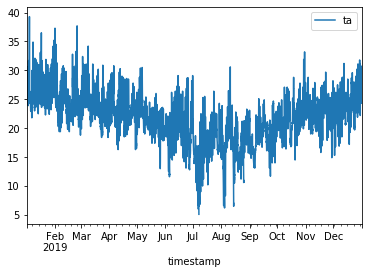

In [2]:
ta_df = pd.read_csv(
    'data/ambient_temperature_hourly.csv',
    header=10,
    date_parser=pd.to_datetime,
    names=['timestamp', 'ta'],
    index_col='timestamp',
)
display(ta_df)
display(ta_df.describe())
ta_df.plot()

Função para plotar multiplos gráficos com eixos diferentes

In [3]:
def plot_multi(data, cols=None, spacing=.1, **kwargs):
    """ https://stackoverflow.com/questions/11640243/pandas-plot-multiple-y-axes """
    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
#     colors = plotting._style._get_standard_colors(num_colors=len(cols))
    colors = getattr(getattr(plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)], **kwargs)
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

# from random import randrange

# data = pd.DataFrame(dict(
#     s1=[randrange(-1000, 1000) for _ in range(100)],
#     s2=[randrange(-100, 100) for _ in range(100)],
#     s3=[randrange(-10, 10) for _ in range(100)],
# ))

# plot_multi(data.cumsum(), figsize=(10, 5))

# Gerando os dados do sensor

,ambiente_temperature,energy,active_power,voltage,current,internal_temperature,cost
count,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000,8751.000000
mean,21.815987,0.038617,38.617012,220.050552,0.175497,5.405698,110.761999
std,4.298974,0.009552,9.552244,1.460232,0.043410,1.628025,58.623800
min,5.100000,0.008466,8.466232,217.505170,0.038282,1.277540,0.037133
25%,19.200000,0.031914,31.913756,218.772179,0.145081,4.113570,62.520543
50%,21.900000,0.037964,37.964356,220.056446,0.172514,5.640733,115.098928
75%,24.600000,0.044817,44.816830,221.323968,0.203588,6.537468,158.090707
max,39.300000,0.078589,78.589295,222.592285,0.354521,8.817413,213.741226


,ambiente_temperature,energy,active_power,voltage,current,internal_temperature,cost,status
timestamp,,,,,,,,
1577840400000,26.9,0.058709,58.709496,222.306388,0.264093,8.033631,0.037133,ON
1577844000000,26.6,0.050323,50.322754,218.541701,0.230266,8.470080,0.068962,ON
1577847600000,26.4,0.055362,55.362325,219.366337,0.252374,8.226947,0.103978,ON
1577851200000,26.5,0.046713,46.713281,217.878645,0.214400,7.777816,0.133523,ON
1577854800000,26.5,0.052837,52.836743,220.270745,0.239872,8.478306,0.166942,ON


,ambiente_temperature,energy,active_power,voltage,current,internal_temperature,cost,status
timestamp,,,,,,,,
1609441200000,29.3,0.060585,60.585490,222.045330,0.272852,7.595381,213.623472,ON
1609444800000,28.0,0.042609,42.609208,218.956545,0.194601,8.021357,213.650421,ON
1609448400000,27.2,0.048010,48.009862,222.006510,0.216254,7.635971,213.680787,ON
1609452000000,26.2,0.041673,41.673315,218.052219,0.191116,7.874624,213.707145,ON
1609455600000,26.3,0.053885,53.884971,220.515770,0.244359,8.093767,213.741226,ON


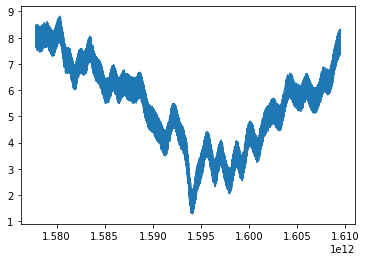

Done: the data for the sensor id 0 was saved to: data/db/0_sensor_0_db.csv


,ambiente_temperature,energy,active_power,voltage,current,internal_temperature,cost
count,8751.000000,8751.000000,8751.000000,8759.000000,8751.000000,8759.000000,8751.000000
mean,21.815987,0.033992,33.991947,220.050117,0.154476,5.606987,106.831617
std,4.298974,0.013755,13.755258,1.460053,0.062519,1.966895,55.774277
min,5.100000,0.000000,0.000000,217.512543,0.000000,1.232679,0.029430
25%,19.200000,0.028800,28.800305,218.764414,0.130993,4.116113,60.706945
50%,21.900000,0.035524,35.524281,220.057805,0.161427,5.672652,111.752391
75%,24.600000,0.042549,42.548536,221.318896,0.193317,6.766108,153.810490
max,39.300000,0.079792,79.792003,222.589634,0.365113,13.175151,188.141962


,ambiente_temperature,energy,active_power,voltage,current,internal_temperature,cost,status
timestamp,,,,,,,,
1577840400000,26.9,0.046530,46.530375,222.289242,0.209324,7.810987,0.029430,ON
1577844000000,26.6,0.049020,49.020415,218.534265,0.224315,8.486007,0.060435,ON
1577847600000,26.4,0.039361,39.360946,219.394058,0.179408,8.497038,0.085330,ON
1577851200000,26.5,0.048856,48.856421,217.942668,0.224171,8.181269,0.116231,ON
1577854800000,26.5,0.047686,47.686076,220.288534,0.216471,8.078031,0.146392,ON


,ambiente_temperature,energy,active_power,voltage,current,internal_temperature,cost,status
timestamp,,,,,,,,
1609441200000,29.3,0.0,0.0,222.052039,0.0,12.398581,188.141962,OFF
1609444800000,28.0,0.0,0.0,218.907265,0.0,12.460852,188.141962,OFF
1609448400000,27.2,0.0,0.0,222.035018,0.0,12.862310,188.141962,OFF
1609452000000,26.2,0.0,0.0,218.026454,0.0,12.715614,188.141962,OFF
1609455600000,26.3,0.0,0.0,220.531183,0.0,13.002479,188.141962,OFF


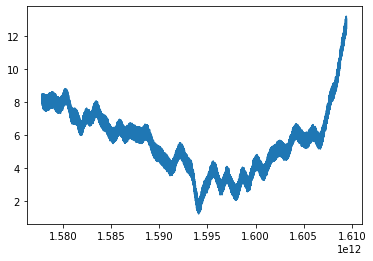

Done: the data for the sensor id 1 was saved to: data/db/0_sensor_1_db.csv


In [5]:
voltage = 220 + (np.random.rand(len(ta_df)) * 5 - 2.5)
basic_energy_tariff = 0.50599 * (1 + 0.25)  # Tarifa residencial B da celesc + aliquota: 12% se menor que 150kWh, 25% se maior.

def generate_sensor_dataframe(df, sensor: dict, verbose=False, plot=False):
    # Change from 2019 to 2020
    df.index += pd.DateOffset(years=1)
    
    df['E'] = (0.6 + 0.4*np.random.rand(len(df))) * sensor['E_hourly'] * df['ta'] / df['ta'].mean() / 1000 # kwh    
    df['P'] = 1000 * df['E'] / 1 # watts
    df['V'] = voltage + 0.1 * np.random.rand(len(df))
    df['I'] = df['P'] / df['V']
    df['ti'] = 4 + np.random.rand(len(df)) + 0.5*df['ta'].rolling(500, win_type='blackman', center=True, min_periods=1).mean() -10
    
    if sensor['sensor_id'] == 1:
        time_now = datetime.now().replace(microsecond=0, second=0, minute=0)
        df.loc[time_now:, ['E', 'P', 'I']] = 0
        df.loc[time_now:, 'ti'] += 0.001 * df.loc[time_now:, 'ti'].cumsum()
        
    df['cost'] = df['E'].cumsum() * basic_energy_tariff
    
    df['status'] = "OFF"
    df.loc[df['I'] > 0, 'status'] = "ON"

    # Convert to epoch in ms
    df.index = (df.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ms')

    df = df.rename(columns={
        "ta": "ambiente_temperature",
        "ti": "internal_temperature",
        "V": "voltage",
        "I": "current",
        "P": "active_power",
        "E": "energy",
        "cost": "cost",
        "status": "status",
    })
    if verbose:
        display(df.describe())
        display(df.head())
        display(df.tail())
    if plot:
        plt.Figure(figsize=(20, 10))
#         plt.plot(df.rolling(1, win_type='blackman', center=True, min_periods=1).mean())
        plt.plot(df['internal_temperature'])
#         plot_multi(df.rolling(25, win_type='blackman', center=True, min_periods=1).mean())
        plt.show()

    output_filename = f"data/db/0_sensor_{int(sensor['sensor_id'])}_db.csv"
    df.to_csv(output_filename, float_format='%.4f')
    print(f"Done: the data for the sensor id {sensor['sensor_id']} was saved to: {output_filename}")
    del df


for sensor_id in [0,1]:
    sensor = generate_freezer_unit(sensor_id)
    generate_sensor_dataframe(ta_df.copy(), sensor, verbose=True, plot=True)